#Assignment 3



*Install* dependencies

In [ ]:
!pip install gymnasium==0.29

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 29.1 MB/s eta 0:00:00


In [ ]:
import gymnasium  as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
import math
from IPython import display


from enum import Enum

class Modes(Enum):
    PoseOnly = 1
    PoseAndLocalMap = 2
    GlobalMap = 3
    PoseAndLocalMapInline = 4


class APA2024SimpleRobotEnv(gym.Env):

    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 60}

    def __init__(self, grid_size,local_grid_size,mode=Modes.PoseOnly):
        super(APA2024SimpleRobotEnv, self).__init__()


        self.grid_size=grid_size
        self.local_grid_size=local_grid_size
        # Define the action space (up, down, left, right)
        self.action_space = spaces.Discrete(3)

        self.mode=mode
        self.TotalReward=0;

        # Define the observation space (grid world with discrete positions)
        self.observation_space = spaces.Discrete(grid_size)
        self.gridmap = np.zeros((self.observation_space.n, self.observation_space.n), dtype = np.float64)
        self.heatmap = np.zeros((self.observation_space.n, self.observation_space.n), dtype = np.int32)
        self.normfactor=math.sqrt(grid_size**2+grid_size**2)

        self.localgridmap = np.zeros((local_grid_size, local_grid_size), dtype = np.float64)

        for i in range(self.observation_space.n):
            self.gridmap[i][0]=1
            self.gridmap[0][i]=1
            self.gridmap[i][self.observation_space.n-1]=1
            self.gridmap[self.observation_space.n-1][i]=1

        # Set the initial state of the robot
        self.robot_position = np.array([0, 0,0])
        self.reset_robot_position= np.array([0, 0,0])

        # Set the goal position
        self.goal_position = np.array([1, 1])
        self.path=[self.robot_position]

        # Set the maximum number of steps
        self.max_steps = 1000

        # Initialize step counter
        self.current_step = 0
        self.gridResolution=0.25;
        self._last_action=-1;
        self._score=0;
        self.render_mode="human"
        self.lastRGB=None
        self.background=None


    @property
    def info(self):
        return {
            "goal": {
                "x": self.goal_position[0],
                "y": self.goal_position[1]
            },
            "robot": {
                "x": self.robot_position[0],
                "y": self.robot_position[1],
                "theta": self.robot_position[2]
            },
            "last_action": self._last_action,
            "score": self._score
        }
    def addObstacle(self,obstacle):
        # Reset the environment to initial state
        x=obstacle[0]/self.gridResolution+self.observation_space.n/2.0
        y=obstacle[1]/self.gridResolution+self.observation_space.n/2.0


        # simple collision checking
        self.gridmap[int(y)][int(x)]=1;

    def addObstacleLine(self, start, end, value):
        """
        Draw a line with the specified value in the environment grid using Bresenham's algorithm.

        Parameters:
            start (tuple): Starting position (x, y).
            end (tuple): Ending position (x, y).
            value (float): Value to fill the line with.

        Returns:
            None
        """

        y0=int(start[1]/self.gridResolution+self.observation_space.n/2.0)
        x0=int(start[0]/self.gridResolution+self.observation_space.n/2.0)
        y1=int(end[1]/self.gridResolution+self.observation_space.n/2.0)
        x1=int(end[0]/self.gridResolution+self.observation_space.n/2.0)


        dx = x1 - x0
        dy = y1 - y0

        xsign = 1 if dx > 0 else -1
        ysign = 1 if dy > 0 else -1

        dx = abs(dx)
        dy = abs(dy)

        if dx > dy:
            xx, xy, yx, yy = xsign, 0, 0, ysign
        else:
            dx, dy = dy, dx
            xx, xy, yx, yy = 0, ysign, xsign, 0

        D = 2*dy - dx
        y = 0

        for x in range(dx + 1):
            self.gridmap[int(y0 + x*xy + y*yy)][int(x0 + x*xx + y*yx)] = value
            if D >= 0:
                y += 1
                D -= 2*dx
            D += 2*dy




    def removeObstacle(self,obstacle):
        # Reset the environment to initial state
        x=obstacle[0]/self.gridResolution+self.observation_space.n/2.0
        y=obstacle[1]/self.gridResolution+self.observation_space.n/2.0


        # simple collision checking
        self.gridmap[int(y)][int(x)]=1;



    def reset(self,seed=-1,options=None):
        # Reset the environment to initial state
        self.robot_position = self.reset_robot_position
        self.current_step = 0
        self.path=[self.robot_position]
        self._last_action=-1
        self._score=0
        self.TotalReward=0
        self.lastdist=np.linalg.norm(self.robot_position[:2] - self.goal_position)

        self.localgridmap = np.zeros((self.local_grid_size, self.local_grid_size), dtype = np.float64)

        if(self.mode==Modes.PoseOnly):
           out=self.robot_position.copy()
           out[0]=self.goal_position[0]-self.robot_position[0]
           out[1]=self.goal_position[1]-self.robot_position[1]
           out[0]=out[0]/math.sqrt(out[0]*out[0]+out[1]*out[1])
           out[1]=out[1]/math.sqrt(out[0]*out[0]+out[1]*out[1])


           return out, self.info

        elif(self.mode==Modes.PoseAndLocalMap):
           out=self.robot_position.copy()
           out[0]=self.goal_position[0]-self.robot_position[0]
           out[1]=self.goal_position[1]-self.robot_position[1]
           out[0]=out[0]/math.sqrt(out[0]*out[0]+out[1]*out[1])
           out[1]=out[1]/math.sqrt(out[0]*out[0]+out[1]*out[1])


           return (out,self.localgridmap), self.info
        elif(self.mode==Modes.PoseAndLocalMapInline):
           out=self.robot_position.copy()
           out[0]=self.goal_position[0]-self.robot_position[0]
           out[1]=self.goal_position[1]-self.robot_position[1]
           out[0]=out[0]/math.sqrt(out[0]*out[0]+out[1]*out[1])
           out[1]=out[1]/math.sqrt(out[0]*out[0]+out[1]*out[1])
           out=np.concatenate((out, self.localgridmap.flatten()), axis=0)

           return out, self.info

        elif(self.mode==Modes.GlobalMap):
           globalmap=self.gridmap.copy()
           return (self.robot_position,globalmap), self.info


        return self.robot_position, self.info


    def setGoal(self,goal):
        # Reset the environment to initial state
        self.goal_position=goal
        self.lastdist=np.linalg.norm(self.robot_position[:2] - self.goal_position)

    def setPosition(self,position):
        # Reset the environment to initial state
        self.robot_position =position
        self.reset_robot_position =position
        self.path=[self.robot_position]



    def step(self, action):
        # Take a step in the environment
        self._last_action=action

        if (action<0):  # to generate still frames
            return self.robot_position, 0, False, False, self.info

        # Define the action mapping
        action_mapping = {
            0: np.array([0.1, 0]),
            1: np.array([0.1, 0.5]),
            2: np.array([0.1, -0.5]),
        }

        h=1.0;
        # Apply the action
        #new_position = self.robot_position + action_mapping[action]
        dxx=h*action_mapping[action][0]*math.cos(self.robot_position[2])
        dyy=h*action_mapping[action][0]*math.sin(self.robot_position[2])
        x = self.robot_position[0] + dxx
        y = self.robot_position[1] + dyy
        theta = self.robot_position[2] + h*action_mapping[action][1]
        theta= math.atan2(math.sin(theta), math.cos(theta))

        collision=0
        # Check if maximum steps reached
        done = self.current_step >= self.max_steps  # defined in this class



        # Check if the new position is valid
        if (-self.gridResolution*self.observation_space.n/2 <= x < self.gridResolution*self.observation_space.n/2) and (-self.gridResolution*self.observation_space.n/2 <= y < self.gridResolution*self.observation_space.n/2):
            self.robot_position = np.array([x, y,theta])
        else:
          #if it is here then it collided with obstacles in the environment
          done=True
          collision=-1000
        x=self.robot_position[0]/self.gridResolution+self.observation_space.n/2.0
        y=self.robot_position[1]/self.gridResolution+self.observation_space.n/2.0

        self.heatmap[int(y)][int(x)]=self.heatmap[int(y)][int(x)]+1

        # simple collision checking
        if self.gridmap[int(y)][int(x)]>0:
          done=True
          collision=-1000

        # Calculate the reward (negative distance to goal)

        d=0.0
        dx=np.linalg.norm(self.robot_position[:2] - self.goal_position)
        delta=self.lastdist-dx
        self.lastdist=dx

        if(dx<0.25 and not done):
          d=100;
          done=True
          print('reached goal')

        #reward = -0.1*dx+d+collision-self.current_step*0.01   #+0.1*delta
        reward = (-math.sqrt(dxx*dxx+dyy*dyy)-dx)/self.normfactor+d+collision
        self.TotalReward =self.TotalReward+reward;
        # Increment step counter
        self.current_step += 1

        self.path.append(self.robot_position)


        self.localgridmap=np.zeros((self.local_grid_size, self.local_grid_size), dtype = np.float64)

        x=self.robot_position[0]/self.gridResolution+self.observation_space.n/2.0
        y=self.robot_position[1]/self.gridResolution+self.observation_space.n/2.0

        xg=int(self.goal_position[0]/self.gridResolution+self.observation_space.n/2.0)
        yg=int(self.goal_position[1]/self.gridResolution+self.observation_space.n/2.0)




        for i in range(self.local_grid_size):
          for j in range(self.local_grid_size):
              if(i==int(xg-x+self.local_grid_size/2) and j==int(yg-y+self.local_grid_size/2) and (0 <= int(x+i-self.local_grid_size/2)<self.observation_space.n and 0 <= int(y+j-self.local_grid_size/2)<self.observation_space.n)):
                 self.localgridmap[j][i]= -1

              elif 0 <= int(x+i-self.local_grid_size/2)<self.observation_space.n and 0 <= int(y+j-self.local_grid_size/2)<self.observation_space.n:
                 self.localgridmap[j][i]= self.gridmap[int(y+j-self.local_grid_size/2)][int(x+i-self.local_grid_size/2)]


        Truncated=done



        if(self.mode==Modes.PoseOnly):
           out=self.robot_position.copy()
           out[0]=self.goal_position[0]-self.robot_position[0]
           out[1]=self.goal_position[1]-self.robot_position[1]
           out[0]=out[0]/math.sqrt(out[0]*out[0]+out[1]*out[1])
           out[1]=out[1]/math.sqrt(out[0]*out[0]+out[1]*out[1])


           return out , reward, done, Truncated, self.info

        elif(self.mode==Modes.PoseAndLocalMap):
           return (self.robot_position,self.localgridmap), reward, done, Truncated, self.info

        elif(self.mode==Modes.PoseAndLocalMapInline):
           out=self.robot_position.copy()
           out[0]=self.goal_position[0]-self.robot_position[0]
           out[1]=self.goal_position[1]-self.robot_position[1]
           out[0]=out[0]/math.sqrt(out[0]*out[0]+out[1]*out[1])
           out[1]=out[1]/math.sqrt(out[0]*out[0]+out[1]*out[1])
           out=np.concatenate((out, self.localgridmap.flatten()), axis=0)

           return out, reward, done, Truncated, self.info

        elif(self.mode==Modes.GlobalMap):
           globalmap=self.gridmap.copy()
           return (self.robot_position,globalmap), reward, done, Truncated, self.info

        return self.robot_position, reward, done, Truncated, self.info

    def render(self):

        if self.render_mode == "human":
          figure, (axes, axes2) = plt.subplots(1, 2)


          #figure, axes = plt.subplots()
          axes.axis([-self.gridResolution*self.observation_space.n/2,self.gridResolution*self.observation_space.n/2,-self.gridResolution*self.observation_space.n/2,self.gridResolution*self.observation_space.n/2])
          axes.axis('square')

          axes2.axis([-self.gridResolution*self.local_grid_size/2,self.gridResolution*self.local_grid_size/2,-self.gridResolution*self.local_grid_size/2,self.gridResolution*self.local_grid_size/2])
          axes2.axis('square')


          for i in range(self.local_grid_size):
              for j in range(self.local_grid_size):
                  if(self.localgridmap[i][j]>0):
                    axes2.add_artist( plt.Rectangle(((j-self.local_grid_size/2)*self.gridResolution, (i-self.local_grid_size/2)*self.gridResolution), self.gridResolution, self.gridResolution, fill=True, color='grey', linewidth=2))
                  elif(self.localgridmap[i][j]<-0.5):
                    axes2.add_artist( plt.Rectangle(((j-self.local_grid_size/2)*self.gridResolution, (i-self.local_grid_size/2)*self.gridResolution), self.gridResolution, self.gridResolution, fill=False, color='black', linewidth=0.1))



          for i in range(self.observation_space.n):
              for j in range(self.observation_space.n):
                  if(self.gridmap[i][j]>0):
                    axes.add_artist( plt.Rectangle(((j-self.observation_space.n/2)*self.gridResolution, (i-self.observation_space.n/2)*self.gridResolution), self.gridResolution, self.gridResolution, fill=True, color='grey', linewidth=2))
                  elif(self.localgridmap[i][j]<-0.5):
                    axes.add_artist( plt.Rectangle(((j-self.observation_space.n/2)*self.gridResolution, (i-self.observation_space.n/2)*self.gridResolution), self.gridResolution, self.gridResolution, fill=False, color='black', linewidth=0.1))

          if(len(self.path))>1:
              for i in range(len(self.path)-1):
                  axes.plot([self.path[i][0],self.path[i+1][0]], [self.path[i][1],self.path[i+1][1]], color='violet', linewidth=1)



          # Display the grid world
          #plt.imshow(grid, cmap='viridis', origin='upper', extent=[0, self.observation_space.n, 0, self.observation_space.n])
          axes.add_artist(plt.Circle((self.robot_position[0], self.robot_position[1]), 0.1, color='blue'))
          axes.add_artist(plt.Circle((self.goal_position[0], self.goal_position[1]), 0.1, color='green'))
          x=[self.robot_position[0],self.robot_position[0]+0.2*math.cos(self.robot_position[2])]
          y=[self.robot_position[1],self.robot_position[1]+0.2*math.sin(self.robot_position[2])]
          #print(self.robot_position[0],self.robot_position[1])


          axes.plot(x, y, color='red', linewidth=1)

          axes2.add_artist(plt.Circle((0, 0), 0.1, color='blue'))

          x=[0,0+0.2*math.cos(self.robot_position[2])]
          y=[0,0+0.2*math.sin(self.robot_position[2])]
          axes2.plot(x, y, color='red', linewidth=1)

          #plt.title("[APA2024] Simple Robot Environment")
          plt.xticks(fontsize=10)
          plt.text(-1.25, -1.55, r'Total Reward: '+str(self.TotalReward), fontsize=10)

          axes2.tick_params(left = False, right = False , labelleft = False ,
                  labelbottom = False, bottom = False)

          display.clear_output(wait=True)
          plt.show()

        if self.render_mode == "rgb_array":

          if(self._last_action==-1 and self.lastRGB is not None):
            return self.lastRGB;


          plt.switch_backend('agg')

          figure, (axes, axes2) = plt.subplots(1, 2)
          canvas = figure.canvas

          axes.axis([-self.gridResolution*self.observation_space.n/2,self.gridResolution*self.observation_space.n/2,-self.gridResolution*self.observation_space.n/2,self.gridResolution*self.observation_space.n/2])
          axes.axis('square')

          axes2.axis([-self.gridResolution*self.local_grid_size/2,self.gridResolution*self.local_grid_size/2,-self.gridResolution*self.local_grid_size/2,self.gridResolution*self.local_grid_size/2])
          axes2.axis('square')

          drawback=1

          if self.background is None:

            for i in range(self.local_grid_size):
                for j in range(self.local_grid_size):
                    if(self.localgridmap[i][j]>0):
                      axes2.add_artist( plt.Rectangle(((j-self.local_grid_size/2)*self.gridResolution, (i-self.local_grid_size/2)*self.gridResolution), self.gridResolution, self.gridResolution, fill=True, color='grey', linewidth=2))
                    elif(self.localgridmap[i][j]<-0.5):
                      axes2.add_artist( plt.Rectangle(((j-self.local_grid_size/2)*self.gridResolution, (i-self.local_grid_size/2)*self.gridResolution), self.gridResolution, self.gridResolution, fill=False, color='black', linewidth=0.1))



            for i in range(self.observation_space.n):
                for j in range(self.observation_space.n):
                    if(self.gridmap[i][j]>0):
                      axes.add_artist( plt.Rectangle(((j-self.observation_space.n/2)*self.gridResolution, (i-self.observation_space.n/2)*self.gridResolution), self.gridResolution, self.gridResolution, fill=True, color='grey', linewidth=2))
                    #elif(self.gridmap[i][j]<-0.5):
                    #  axes.add_artist( plt.Rectangle(((j-self.observation_space.n/2)*self.gridResolution, (i-self.observation_space.n/2)*self.gridResolution), self.gridResolution, self.gridResolution, fill=False, color='black', linewidth=0.1))

            axes2.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)


          if(len(self.path))>1:
            for i in range(len(self.path)-1):
                axes.plot([self.path[i][0],self.path[i+1][0]], [self.path[i][1],self.path[i+1][1]], color='violet', linewidth=1)



          # Display the grid world
          axes.add_artist(plt.Circle((self.robot_position[0], self.robot_position[1]), 0.1, color='blue'))
          axes.add_artist(plt.Circle((self.goal_position[0], self.goal_position[1]), 0.1, color='green'))
          x=[self.robot_position[0],self.robot_position[0]+0.2*math.cos(self.robot_position[2])]
          y=[self.robot_position[1],self.robot_position[1]+0.2*math.sin(self.robot_position[2])]


          axes.plot(x, y, color='red', linewidth=1)

          axes2.add_artist(plt.Circle((0, 0), 0.1, color='blue'))

          x=[0,0+0.2*math.cos(self.robot_position[2])]
          y=[0,0+0.2*math.sin(self.robot_position[2])]
          axes2.plot(x, y, color='red', linewidth=1)

          #plt.title("[APA2024] Simple Robot Environment")
          plt.xticks(fontsize=10)
          plt.text(-1.25, -1.55, r'Total Reward: '+str(self.TotalReward), fontsize=10)
          axes2.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)


          canvas.draw();
          image_flat = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')  # (H * W * 3,)
          image = image_flat.reshape(*reversed(canvas.get_width_height()), 3)  # (H, W, 3)
          plt.close()
          self.lastRGB=image;
          #if(drawback==1):
          #self.lastRGB=self.lastRGB+self.background
          return image;




In [ ]:
# Usage example:
env = APA2024SimpleRobotEnv(grid_size=50,local_grid_size=11)
observation = env.reset()
env.setGoal(np.array([5, 5]))
env.setPosition(np.array([-2,-2.5,0 ]))

Deep RL Replay Buffer

In [ ]:
class ReplayBuffer:
    def __init__(self, size):
        self.size = size
        self.counter = 0
        self.state_buffer = []
        self.action_buffer = []
        self.reward_buffer = []
        self.new_state_buffer = []
        self.terminal_buffer = []

    def store_tuples(self, state, action, reward, new_state, done):
        if len(self.state_buffer) < self.size:
            self.state_buffer.append(None)
            self.action_buffer.append(None)
            self.reward_buffer.append(None)
            self.new_state_buffer.append(None)
            self.terminal_buffer.append(None)

        self.counter = self.counter % self.size
        self.state_buffer[self.counter] = state
        self.action_buffer[self.counter] = action
        self.reward_buffer[self.counter] = reward
        self.new_state_buffer[self.counter] = new_state
        self.terminal_buffer[self.counter] = done

        #reward propagation (collision only)
        if(reward.item()<-750.0):
            self.reward_buffer[self.counter-1]=self.reward_buffer[self.counter-1]+reward
            self.reward_buffer[self.counter-2]=self.reward_buffer[self.counter-2]+reward
            self.reward_buffer[self.counter-3]=self.reward_buffer[self.counter-3]+reward
            self.reward_buffer[self.counter-4]=self.reward_buffer[self.counter-4]+reward


        self.counter += 1

    def sample_buffer(self, batch_size):
        max_buffer = min(self.counter, self.size)
        batch = np.random.choice(max_buffer, batch_size, replace=False)
        state_batch=[];
        action_batch=[];
        reward_batch=[];
        new_state_batch=[];
        done_batch=[];

        for a in batch:
            state_batch.append(self.state_buffer[a])
            action_batch.append(self.action_buffer[a])
            reward_batch.append(self.reward_buffer[a])
            new_state_batch.append(self.new_state_buffer[a])
            done_batch.append(self.terminal_buffer[a])
        return state_batch, action_batch, reward_batch, new_state_batch, done_batch





Default DQN arquitecture

In [ ]:
from torchvision import datasets, models
import torch.nn as nn
import torch
from torch.utils import data
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import random

import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


class DQN(nn.Module):

    def __init__(self, inputs, outputs):
        super(DQN, self).__init__()

        self.input_size=inputs;
        self.output_size=outputs;

        self.features = nn.Sequential(
            nn.Linear(inputs, 1024),
            nn.GELU(),
            nn.Linear(1024, 512),
            nn.GELU(),
            nn.Linear(512, 256),
            nn.GELU(),
        )

        # Standard DQN path
        self.layers = nn.Sequential(
            nn.Linear(256, 512),
            nn.GELU(),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Linear(256, outputs),
        )

        # Dueling network architecture
        self.layersdueling = nn.Sequential(
            nn.Linear(256, 512),
            nn.GELU(),
            nn.Linear(512, 256),
            nn.GELU(),
        )

        self.advantage = nn.Sequential(
            nn.Linear(256, outputs),
        )

        self.value = nn.Sequential(
            nn.Linear(256, 1),
        )
###### DQN/Double DQN configuration

###########    ############    #################
#         #    #          #    #               #
#   IMG   # -> # features # -> #     layers    #    .... argmax ....
#         #    #  (CONVs) #    #     (FCs)     #
###########    ############    #################


###### Dueling configuration
                                                    #############
###########    ############    #################    # advantage #
#         #    #          #    #               # -> #############   ... value + advantage  - advantage.mean() ... argmax ...
#   IMG   # -> # features # -> # layersdueling # -> #############
#         #    #  (CONVs) #    #     (FCs)     #    #   value   #
###########    ############    #################    #############


    def forward(self, x):

        if(useDueling):
            x = x.view(x.size(0), -1)
            x=self.features(x)
            x = x.view(x.size(0), -1)
            x = self.layersdueling(x)
            advantage = self.advantage(x)
            value     = self.value(x)
            return value + advantage  - advantage.mean()
        else:
            x = x.view(x.size(0), -1)
            x=self.features(x)
            x = x.view(x.size(0), -1)
            return self.layers(x)

    def policy(self,state):
       with torch.no_grad():
            return self.__call__(state.unsqueeze(0)).argmax()

    def getPolicy(self,state,eps_threshold):
        sample = random.random()
        if sample > eps_threshold:
            with torch.no_grad():
                return self.__call__(state.unsqueeze(0)).argmax()
        else:
            return  torch.tensor(random.randrange(self.output_size), device=device, dtype=torch.long)



In [ ]:
!pip install torchviz

In [ ]:
from torchviz import make_dot

# Disable dueling for simplicity
useDueling = False

# Define the model
model = DQN(12 * 96 * 96, 5)

# Create a dummy input tensor and flatten it
dummy_input = torch.randn(1, 12, 96, 96)
dummy_input_flat = dummy_input.view(1, -1)  # Flatten the input

# Generate the computational graph
make_dot(model(dummy_input_flat), params=dict(model.named_parameters())).render("dqn_architecture", format="png")



'dqn_architecture.png'

OpenAI Environment CarRacing-v2


###    Description:
        Continuous or discrete control task to learn from pixels, a top-down racing environment.
###    Observation:
        Type: Image (96x96x3)
        Some indicators are shown at the bottom of the window along with the state RGB buffer. From left to right: the true speed, four ABS sensors, the steering wheel position and gyroscope.
###    Actions:
        Discrete Mode: 'nothing','left','right','gas','brake'
        Continuous Mode: 3 different variables can be modified: steering wheel, gas, and brake. For the methods explored in this Colab, discrete control commands are reasonable (a set of control commands is provided for this mode).
###    Reward:
        The reward is -0.1 every frame and +1000/N for every track tile visited, where N is the total number of tiles visited in the track. For example, if you have finished in 732 frames, your reward is 1000 - 0.1*732 = 926.8 points.
###    Starting State:
        The tracks and colors are randomly generated with UseRandomize=True for each episode. With UseRandomize=False, only the tracks are random.
###    Episode Termination:
        Car is too faraway from the track.
        Car accumulated a negative reward after given iterations (see ResetCounter and InitCounter).
        Episode length is greater than 1000.
        All tiles are visited.
###     Solved Requirements:
        The game is solved when the agent consistently gets 900+ points. For this assignment a minimum of 200 points are required.


DQN movie generation (for visual evaluation in Google Colab)

In [ ]:
from gymnasium.wrappers.record_video import RecordVideo
def createMovie(Network,Filename):
    env.render_mode="rgb_array"
    new_state, _ = env.reset(options={})#,seed=6)  # weird behaviour using the gym API

    env1 = env
    envX = RecordVideo(env1, video_folder='./videos/'+Filename,  episode_trigger = lambda episode_number: True)

    new_state, _ = envX.reset(options={})#,seed=6)
    envX.start_video_recorder()

    if(envX.unwrapped.mode==Modes.PoseAndLocalMapInline):
      stackedStateX=[new_state for i in range(FrameStack)];
      state=torch.from_numpy(np.reshape(np.array(stackedStateX),(FrameStack,3+envX.unwrapped.local_grid_size*envX.unwrapped.local_grid_size,1))).float().to(device)


    elif(envX.unwrapped.mode==Modes.PoseOnly):
      stackedStateX=[new_state for i in range(FrameStack)];
      state=torch.from_numpy(np.reshape(np.array(stackedStateX),(FrameStack,3,1))).float().to(device)

    elif(envX.unwrapped.mode==Modes.PoseAndLocalMap):
      stackedStateX=[np.rollaxis(new_state[1], 2, 0).copy() for i in range(FrameStack)];
      state=torch.from_numpy(np.reshape(np.array(stackedStateX),(FrameStack,envX.unwrapped.local_grid_size,envX.unwrapped.local_grid_size))).float().to(device)
      stackedStatepose=[new_state[0] for i in range(FrameStack)];
      statepose=torch.from_numpy(np.reshape(np.array(stackedStatepose),(FrameStack,3,1))).float().to(device)

    elif(envX.unwrapped.mode==Modes.GlobalMap):
      stackedStateX=[np.rollaxis(new_state, 2, 0).copy() for i in range(FrameStack)];
      state=torch.from_numpy(np.reshape(np.array(stackedStateX),(FrameStack,envX.unwrapped.grid_size,envX.unwrapped.grid_size))).float().to(device)


    Network.eval()
    resetStatus=0;


    while True:
        envX.render()

        action = Network.policy(state);
        reward=0
        for x in range(ControlSteps):
            new_state, r, done, truncated, _  = envX.step(action.item())
            reward+=r
            for i in range(FPS-1):
                envX.step(-1)
            if(done or truncated):
                break



        stackedStateX.pop(0)



        if(envX.unwrapped.mode==Modes.PoseAndLocalMapInline):
          stackedStateX.append(new_state.copy())
          state=torch.from_numpy(np.reshape(np.array(stackedStateX),(FrameStack,3+envX.unwrapped.local_grid_size*envX.unwrapped.local_grid_size,1))).float().to(device)

        elif(envX.unwrapped.mode==Modes.PoseOnly):
          stackedStateX.append(new_state.copy())
          state=torch.from_numpy(np.reshape(np.array(stackedStateX),(FrameStack,3,1))).float().to(device)

        elif(envX.unwrapped.mode==Modes.PoseAndLocalMap):
          stackedStateX.append(np.rollaxis(new_state[1], 2, 0).copy())
          state=torch.from_numpy(np.reshape(np.array(stackedStateX),(FrameStack,envX.unwrapped.local_grid_size,envX.unwrapped.local_grid_size))).float().to(device)
          stackedStatepose.pop(0)
          stackedStatepose.append(new_state[0].copy())
          statepose=torch.from_numpy(np.reshape(np.array(stackedStatepose),(FrameStack,3,1))).float().to(device)

        elif(envX.unwrapped.mode==Modes.GlobalMap):
          stackedStateX.append(np.rollaxis(new_state, 2, 0).copy())
          state=torch.from_numpy(np.reshape(np.array(stackedStateX),(FrameStack,envX.unwrapped.grid_size,envX.unwrapped.grid_size))).float().to(device)

        if done or truncated: #or resetStatus>=ResetCounter:
          break;

    envX.close()
    env1.close();
    Network.train()
    mp4list = glob.glob('./videos/'+Filename+'/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

Dummy Net with random policy

In [ ]:
class RandomNet(nn.Module):

    def __init__(self,outputs):
        super(RandomNet, self).__init__()
        self.output_size=outputs;


    def forward(self, x):
        return  x

    def policy(self,state):
       return  torch.tensor([[random.randrange(self.output_size)]], device=device, dtype=torch.long)


Parameters

In [ ]:
env = APA2024SimpleRobotEnv(grid_size=50,local_grid_size=11)
observation = env.reset()
env.setGoal(np.array([5, 5]))
env.setPosition(np.array([2,-2.5,0 ]))

In [ ]:

n_actions=3

FPS=30

#hyper-parameters
TotalEpisodes=500;
MaxSteps=500;
ControlSteps=6; # number of iterations the same action is executed in the environment
FrameStack=1 # number of consecutive frames used to represent the state
FreezeCounter=25; # clone the model every X episodes
BatchSize=128;
exploration_threshold=1
exploration_threshold_min=0.01
exploration_decay=0.0025
discount_factor=0.998
LearningRate=0.0001

SaveAtCounter=50 # save model or video at every X episodes
ResetCounter=30 # maximum number of experiences with bad performance (max=InitCounter+ResetCounter)
InitCounter=30 # minimum number of experiences per episode
FrameSize=3; # 3 if RGB 1 if grayscale

BufferSize=150000  # max number of experiences in the buffer (may need to be smaller if CUDA memory errors occur).

# use these flags to enable Double DQN and Duelinng (Dueling DQN or Double Dueling DQN)
usedoubleDQN=False
useDueling=True

env.max_steps=MaxSteps


Run the new netwwork with random policy

In [ ]:
randomnet=RandomNet(n_actions)
createMovie(randomnet,"random")

/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:297: UserWarning: WARN: env.is_vector_env to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.is_vector_env` for environment variables or `env.get_attr('is_vector_env')` that will search the reminding wrappers.
  logger.warn(
<ipython-input-2-3b6d9a0b446d>:465: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image_flat = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')  # (H * W * 3,)


Moviepy - Building video /content/videos/random/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/random/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/random/rl-video-episode-0.mp4


<ipython-input-2-3b6d9a0b446d>:465: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image_flat = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')  # (H * W * 3,)


Moviepy - Building video /content/videos/random/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/random/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/random/rl-video-episode-0.mp4


Initialization and Parameters:


In [ ]:


#network DQN
policy_net = DQN(3*FrameStack, n_actions).to(device)
target_net = DQN(3*FrameStack, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

buffer = ReplayBuffer(BufferSize);

optimizer = torch.optim.Adam(policy_net.parameters(), lr=LearningRate)

loss=  torch.nn.SmoothL1Loss()


DQN training

In [ ]:
def trainModel(buffer_data):
    if buffer_data.counter < BatchSize:
        return 0.0

    state_batch, action_batch, reward_batch, new_state_batch, done_batch = buffer_data.sample_buffer(BatchSize)
    state_batch = torch.stack(state_batch).to(device)
    action_batch = torch.stack(action_batch).reshape(-1,1).to(device)
    new_state_batch = torch.stack(new_state_batch).to(device)
    reward_batch = torch.stack(reward_batch).reshape(-1,1).to(device)
    done_batch = torch.stack(done_batch).reshape(-1,1).to(device)


    if usedoubleDQN:


      q_actual = torch.gather(policy_net(state_batch),1,index=action_batch)
      with torch.no_grad():
        _,action_new = policy_net(new_state_batch).max(dim=1)#.max(dim=1)
        action_new_oneshot=action_new.reshape(-1, 1)
        q_next=torch.gather(target_net(new_state_batch),1,index=action_new_oneshot)
        q_next=q_next.reshape(-1, 1)

      q_target = (q_next * discount_factor)*(1-done_batch) + reward_batch

      ll=loss(q_actual, q_target)


    else:
        q_actual = torch.gather(policy_net(state_batch),1,index=action_batch)
        with torch.no_grad():
            q_max_next, _ = target_net(new_state_batch).max(dim=1)
            q_max_next=q_max_next.reshape(-1, 1)

        q_target = (q_max_next * discount_factor)*(1-done_batch) + reward_batch
        ll=loss(q_actual, q_target)

    optimizer.zero_grad()
    ll.backward()
    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 1)
    optimizer.step()

    return ll.item();

In [ ]:
import copy


loss_val,scores, episodes,events, avg_scores,avg_scores20,exploration = [],[],[], [],[], [], []

bestScore=-99999;
at=0;
bestNet=copy.deepcopy(policy_net);


for f in range(TotalEpisodes):
    done  = False
    score = 0.0
    tloss = 0.0

    new_state,_=env.reset()

    if(env.mode==Modes.PoseAndLocalMapInline):
      stackedStateX=[new_state for i in range(FrameStack)];
      state=torch.from_numpy(np.reshape(np.array(stackedStateX),(FrameStack,3+env.local_grid_size*env.local_grid_size,1))).float().to(device)

    elif(env.mode==Modes.PoseOnly):
      stackedStateX=[new_state for i in range(FrameStack)];
      state=torch.from_numpy(np.reshape(np.array(stackedStateX),(FrameStack,3,1))).float().to(device)
      #print("111 ",len(stackedStateX),FrameStack)

    elif(env.mode==Modes.PoseAndLocalMap):
      stackedStateX=[np.rollaxis(new_state[1], 2, 0).copy() for i in range(FrameStack)];
      state=torch.from_numpy(np.reshape(np.array(stackedStateX),(FrameStack,env.local_grid_size,env.local_grid_size))).float().to(device)
      stackedStatepose=[new_state[0] for i in range(FrameStack)];
      statepose=torch.from_numpy(np.reshape(np.array(stackedStatepose),(FrameStack,3,1))).float().to(device)

    elif(env.mode==Modes.GlobalMap):
      stackedStateX=[np.rollaxis(new_state, 2, 0).copy() for i in range(FrameStack)];
      state=torch.from_numpy(np.reshape(np.array(stackedStateX),(FrameStack,env.grid_size,env.grid_size))).float().to(device)



    if f % FreezeCounter == 0:
       print("########################################"+str(f)+" of "+str(TotalEpisodes), exploration_threshold)
       target_net.load_state_dict(policy_net.state_dict())

    resetStatus=0;
    i=0

    for F in range(MaxSteps):
        action = policy_net.getPolicy(state,exploration_threshold)
        reward=0
        for _ in range(ControlSteps):
            new_state, r, done,trunc, info = env.step(action.item())
            reward+=r
            i=i+1
            if(done or trunc):
                break

        oldstate=state.clone();
        stackedStateX.pop(0)


        if(env.mode==Modes.PoseAndLocalMapInline):
          stackedStateX.append(new_state.copy())
          state=torch.from_numpy(np.reshape(np.array(stackedStateX),(FrameStack,3+env.local_grid_size*env.local_grid_size,1))).float().to(device)

        elif(env.mode==Modes.PoseOnly):
          stackedStateX.append(new_state.copy())
          state=torch.from_numpy(np.reshape(np.array(stackedStateX),(FrameStack,3,1))).float().to(device)

        elif(env.mode==Modes.PoseAndLocalMap):
          stackedStateX.append(np.rollaxis(new_state[1], 2, 0).copy())
          state=torch.from_numpy(np.reshape(np.array(stackedStateX),(FrameStack,env.local_grid_size,env.local_grid_size))).float().to(device)
          stackedStatepose.pop(0)
          stackedStatepose.append(new_state[0].copy())
          statepose=torch.from_numpy(np.reshape(np.array(stackedStatepose),(FrameStack,3,1))).float().to(device)

        elif(env.mode==Modes.GlobalMap):
          stackedStateX.append(np.rollaxis(new_state, 2, 0).copy())
          state=torch.from_numpy(np.reshape(np.array(stackedStateX),(FrameStack,env.grid_size,env.grid_size))).float().to(device)


        score += reward
        if(F<(MaxSteps-1)):
            buffer.store_tuples(oldstate, action, torch.tensor(reward), state, torch.tensor(int(done)))

        trainModel(buffer)

        if(done or trunc):
            break
    exploration_threshold= exploration_threshold-exploration_decay if exploration_threshold > exploration_threshold_min else exploration_threshold_min
    print("EP: ",score," It: ",F," eth: ",exploration_threshold)

    if(score>bestScore and exploration_threshold<0.1):
        print("Best EP: ",score," It: ",F," eth: ",exploration_threshold)
        bestScore=score;
        bestNet=copy.deepcopy(policy_net);
        at=f;

    exploration.append(exploration_threshold)
    scores.append(score)
    episodes.append(f)
    events.append(F)
    avg_scores.append(score/F)
    avg_scores20.append(np.mean(scores[-20:]))


torch.save(bestNet.state_dict(), 'BestRobot_model.ckpt')


########################################0 of 500 1
EP:  -1015.4676181075608  It:  24  eth:  0.9975
EP:  -47.78775211259486  It:  83  eth:  0.9950000000000001
EP:  -1073.2093581260017  It:  77  eth:  0.9925000000000002
EP:  -58.417742888008775  It:  83  eth:  0.9900000000000002
EP:  -1057.1123335502737  It:  63  eth:  0.9875000000000003
EP:  -57.23840428802951  It:  83  eth:  0.9850000000000003
EP:  -1055.0239067054  It:  72  eth:  0.9825000000000004
EP:  -49.42805801699213  It:  83  eth:  0.9800000000000004
EP:  -55.1024137089352  It:  83  eth:  0.9775000000000005
EP:  -69.32949086713235  It:  83  eth:  0.9750000000000005
EP:  -1014.334393121051  It:  25  eth:  0.9725000000000006
EP:  -1028.346867992762  It:  33  eth:  0.9700000000000006
EP:  -1024.2559849762263  It:  30  eth:  0.9675000000000007
EP:  -1032.0041247286492  It:  48  eth:  0.9650000000000007
EP:  -65.74893551104854  It:  83  eth:  0.9625000000000008
EP:  -40.34785180148116  It:  83  eth:  0.9600000000000009
EP:  -1030.501

Plot performance

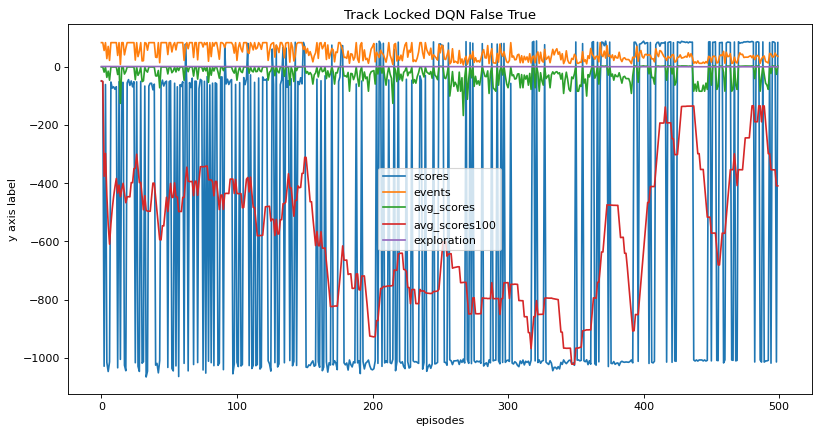

In [ ]:
import matplotlib
matplotlib.use('module://matplotlib_inline.backend_inline')
plt.figure(figsize=(12, 6), dpi=80)
plt.plot(episodes, scores)
plt.plot(episodes, events)
plt.plot(episodes, avg_scores)
plt.plot(episodes, avg_scores20)
plt.plot(episodes, exploration)
plt.xlabel('episodes')
plt.ylabel('y axis label')

plt.title('Track Locked DQN '+str(usedoubleDQN)+' '+str(useDueling))
plt.legend(['scores', 'events', 'avg_scores', 'avg_scores100','exploration'])

plt.show()

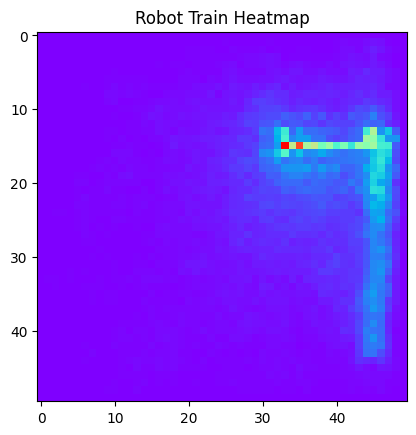

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data = env.heatmap/(np.max(env.heatmap))


plt.imshow(data, cmap='rainbow')

plt.title("Robot Train Heatmap")
plt.show()

*View* Best Results

In [ ]:
#env.setGoal(np.array([5, 5]))
#env.setPosition(np.array([-2,-2.5,0 ]))
createMovie(bestNet,'bestNet')




/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:297: UserWarning: WARN: env.is_vector_env to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.is_vector_env` for environment variables or `env.get_attr('is_vector_env')` that will search the reminding wrappers.
  logger.warn(
<ipython-input-2-3b6d9a0b446d>:465: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image_flat = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')  # (H * W * 3,)


Moviepy - Building video /content/videos/bestNet/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/bestNet/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/bestNet/rl-video-episode-0.mp4


<ipython-input-2-3b6d9a0b446d>:465: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image_flat = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')  # (H * W * 3,)


Moviepy - Building video /content/videos/bestNet/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/bestNet/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/bestNet/rl-video-episode-0.mp4


In [ ]:
# Usage example:
env = APA2024SimpleRobotEnv(grid_size=50,local_grid_size=11,mode=Modes.PoseAndLocalMapInline)
observation = env.reset()
env.setGoal(np.array([5, 5]))
env.setPosition(np.array([-2,-2.5,0 ]))


env.addObstacleLine(np.array([0,-2]),np.array([ -5.9,-2]),1)
env.addObstacleLine(np.array([0, -2]),np.array([0, 5.9]),1)


env.addObstacleLine(np.array([2,-4]),np.array([ -5.9,-4]),1)
env.addObstacleLine(np.array([2, -4]),np.array([2, 4]),1)


env.addObstacleLine(np.array([2,4]),np.array([ 5.9,4]),1)


env.max_steps=5

env.setPosition(np.array([-2,-2.5,0 ]))
createMovie(randomnet,'bestNet')



/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/videos/bestNet folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:297: UserWarning: WARN: env.is_vector_env to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.is_vector_env` for environment variables or `env.get_attr('is_vector_env')` that will search the reminding wrappers.
  logger.warn(
<ipython-input-2-3b6d9a0b446d>:465: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image_flat = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')  # (H * W * 3,)


Moviepy - Building video /content/videos/bestNet/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/bestNet/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/bestNet/rl-video-episode-0.mp4
Moviepy - Building video /content/videos/bestNet/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/bestNet/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/bestNet/rl-video-episode-0.mp4


In [ ]:


#env.addObstacleLine(np.array([-5.9, 4]),np.array([-2, 4]),1)
#env.addObstacleLine(np.array([-5.9, 2]),np.array([-2, 2]),1)
#env.addObstacleLine(np.array([-5.9, 0]),np.array([-1, 0]),1)
#env.addObstacleLine(np.array([-5.9, -4]),np.array([0, -4]),1)


#env.addObstacleLine(np.array([2, 3]),np.array([5.9, 3]),1)
#env.addObstacleLine(np.array([2, 1]),np.array([5.9, 1]),1)
#env.addObstacleLine(np.array([0, -1]),np.array([5.9, -1]),1)
#env.addObstacleLine(np.array([0, -3]),np.array([5.9, -3]),1)




#hyper-parameters
TotalEpisodes=2500;
MaxSteps=250;
ControlSteps=6; # number of iterations the same action is executed in the environment
FrameStack=4 # number of consecutive frames used to represent the state
FreezeCounter=25; # clone the model every X episodes
BatchSize=512;
exploration_threshold=1
exploration_threshold_min=0.01
exploration_decay=0.0013/2.5
discount_factor=0.95
LearningRate=0.001


env.max_steps=MaxSteps



#network DQN
policy_net = DQN((3+11*11)*FrameStack, n_actions).to(device)
target_net = DQN((3+11*11)*FrameStack, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

buffer = ReplayBuffer(BufferSize);

optimizer = torch.optim.Adam(policy_net.parameters(), lr=LearningRate)

loss=  torch.nn.SmoothL1Loss()



import copy


loss_val,scores, episodes,events, avg_scores,avg_scores20,exploration = [],[],[], [],[], [], []

bestScore=-99999;
at=0;
bestNet=copy.deepcopy(policy_net);


for f in range(TotalEpisodes):
    done  = False
    score = 0.0
    tloss = 0.0

    new_state,_=env.reset()

    if(env.mode==Modes.PoseAndLocalMapInline):
      stackedStateX=[new_state for i in range(FrameStack)];
      state=torch.from_numpy(np.reshape(np.array(stackedStateX),(FrameStack,3+env.local_grid_size*env.local_grid_size,1))).float().to(device)

    if(env.mode==Modes.PoseOnly ):
      stackedStateX=[new_state for i in range(FrameStack)];
      state=torch.from_numpy(np.reshape(np.array(stackedStateX),(FrameStack,3,1))).float().to(device)

    if(env.mode==Modes.PoseAndLocalMap):
      stackedStateX=[np.rollaxis(new_state[1], 2, 0).copy() for i in range(FrameStack)];
      state=torch.from_numpy(np.reshape(np.array(stackedStateX),(FrameStack,env.local_grid_size,env.local_grid_size))).float().to(device)
      stackedStatepose=[new_state[0] for i in range(FrameStack)];
      statepose=torch.from_numpy(np.reshape(np.array(stackedStatepose),(FrameStack,3,1))).float().to(device)

    if(env.mode==Modes.GlobalMap):
      stackedStateX=[np.rollaxis(new_state, 2, 0).copy() for i in range(FrameStack)];
      state=torch.from_numpy(np.reshape(np.array(stackedStateX),(FrameStack,env.grid_size,env.grid_size))).float().to(device)


    if f % FreezeCounter == 0:
       print("########################################"+str(f)+" of "+str(TotalEpisodes), exploration_threshold)
       target_net.load_state_dict(policy_net.state_dict())

    resetStatus=0;
    i=0

    for F in range(MaxSteps):
        action = policy_net.getPolicy(state,exploration_threshold)
        reward=0
        for _ in range(ControlSteps):
            new_state, r, done,trunc, info = env.step(action.item())
            reward+=r
            i=i+1
            if(done or trunc):
                break

        oldstate=state.clone();
        stackedStateX.pop(0)

        if(env.mode==Modes.PoseAndLocalMapInline):
          stackedStateX.append(new_state.copy())
          state=torch.from_numpy(np.reshape(np.array(stackedStateX),(FrameStack,3+env.local_grid_size*env.local_grid_size,1))).float().to(device)

        if(env.mode==Modes.PoseOnly):
          stackedStateX.append(new_state.copy())
          state=torch.from_numpy(np.reshape(np.array(stackedStateX),(FrameStack,3,1))).float().to(device)

        if(env.mode==Modes.PoseAndLocalMap):
          stackedStateX.append(np.rollaxis(new_state[1], 2, 0).copy())
          state=torch.from_numpy(np.reshape(np.array(stackedStateX),(FrameStack,env.local_grid_size,env.local_grid_size))).float().to(device)
          stackedStatepose.pop(0)
          stackedStatepose.append(new_state[0].copy())
          statepose=torch.from_numpy(np.reshape(np.array(stackedStatepose),(FrameStack,3,1))).float().to(device)

        if(env.mode==Modes.GlobalMap):
          stackedStateX.append(np.rollaxis(new_state, 2, 0).copy())
          state=torch.from_numpy(np.reshape(np.array(stackedStateX),(FrameStack,env.grid_size,env.grid_size))).float().to(device)


        score += reward
        if(F<(MaxSteps-1)):
            buffer.store_tuples(oldstate, action, torch.tensor(reward), state, torch.tensor(int(done)))

        trainModel(buffer)


        if(done or trunc):
            break
    exploration_threshold= exploration_threshold-exploration_decay if exploration_threshold > exploration_threshold_min else exploration_threshold_min
    print("EP: ",score," It: ",F," eth: ",exploration_threshold)

    if(score>bestScore and exploration_threshold<0.1):
        print("Best EP: ",score," It: ",F," eth: ",exploration_threshold)
        bestScore=score;
        torch.save(policy_net.state_dict(), 'BestRobot_model.ckpt')
        at=f;

    exploration.append(exploration_threshold)
    scores.append(score)
    episodes.append(f)
    events.append(F)
    avg_scores.append(score/F)
    avg_scores20.append(np.mean(scores[-20:]))


#





########################################0 of 2500 1
EP:  -1025.3935808425442  It:  34  eth:  0.99948
EP:  -32.22462414337725  It:  41  eth:  0.9989600000000001
EP:  -1024.9721813811602  It:  36  eth:  0.9984400000000001
EP:  -33.085125030349886  It:  41  eth:  0.9979200000000001
EP:  -29.497099840527934  It:  41  eth:  0.9974000000000002
EP:  -1005.9055931897641  It:  8  eth:  0.9968800000000002
EP:  -1003.6502085747816  It:  5  eth:  0.9963600000000002
EP:  -1013.700681769764  It:  22  eth:  0.9958400000000003
EP:  -1008.0406295379327  It:  12  eth:  0.9953200000000003
EP:  -29.548965677349788  It:  41  eth:  0.9948000000000004
EP:  -1028.5277787771122  It:  38  eth:  0.9942800000000004
EP:  -1012.625900343432  It:  15  eth:  0.9937600000000004
EP:  -1005.474848369699  It:  8  eth:  0.9932400000000005
EP:  -1010.5990500759611  It:  16  eth:  0.9927200000000005
EP:  -30.968297378078606  It:  41  eth:  0.9922000000000005
EP:  -30.955406852356557  It:  41  eth:  0.9916800000000006
EP:  -

RuntimeError: mat1 and mat2 shapes cannot be multiplied (512x12 and 496x1024)

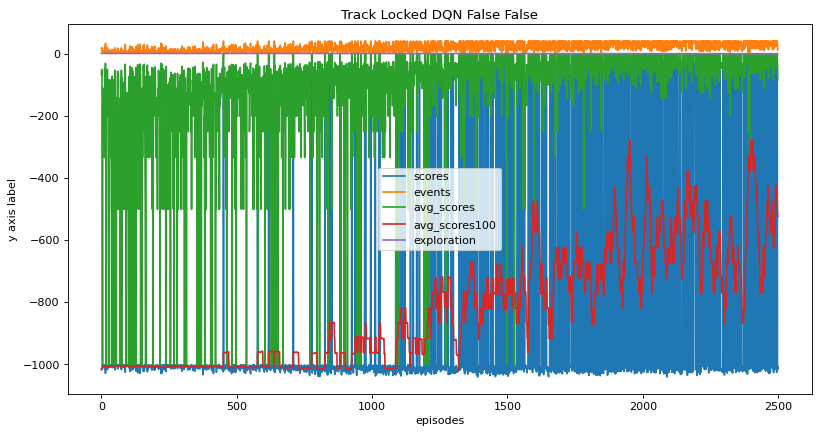

In [ ]:
import matplotlib
matplotlib.use('module://matplotlib_inline.backend_inline')
plt.figure(figsize=(12, 6), dpi=80)
plt.plot(episodes, scores)
plt.plot(episodes, events)
plt.plot(episodes, avg_scores)
plt.plot(episodes, avg_scores20)
plt.plot(episodes, exploration)
plt.xlabel('episodes')
plt.ylabel('y axis label')

plt.title('Track Locked DQN '+str(usedoubleDQN)+' '+str(useDueling))
plt.legend(['scores', 'events', 'avg_scores', 'avg_scores100','exploration'])

plt.show()

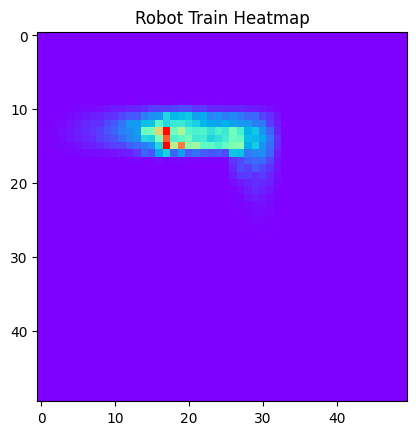

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data = env.heatmap/(np.max(env.heatmap))

plt.imshow(data, cmap='rainbow')

plt.title("Robot Train Heatmap")
plt.show()




In [ ]:
policy_net.load_state_dict(torch.load('BestRobot_model.ckpt'))
createMovie(policy_net,'bestNet')


<ipython-input-55-8ca3508b9323>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy_net.load_state_dict(torch.load('BestRobot_model.ckpt'))


Moviepy - Building video /content/videos/bestNet/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/bestNet/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/bestNet/rl-video-episode-0.mp4


<ipython-input-2-3b6d9a0b446d>:465: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image_flat = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')  # (H * W * 3,)


Moviepy - Building video /content/videos/bestNet/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/bestNet/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/bestNet/rl-video-episode-0.mp4
